In [30]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

In [5]:
df = pd.read_csv('input/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
csv_columns = ['Survived', 'Pclass', 'Sex', 'Age',
               'SibSp', 'Parch', 'Fare', 'Cabin']

record_defaults = [[0], [0], [''], [0.],
                   [0], [0], [0.], ['']]

num_examples = 700

run_config = tf.estimator.RunConfig().replace(
    session_config=tf.ConfigProto(device_count={'GPU': 0}))

def get_model_columns():
    pclass = tf.feature_column.numeric_column('Pclass', dtype=tf.int32)
    sex = tf.feature_column.categorical_column_with_vocabulary_list(
        'Sex', ['male', 'female'])
    age = tf.feature_column.numeric_column('Age')
    age_buckets = tf.feature_column.bucketized_column(
        age, boundaries=[5., 10., 18., 30., 40., 50., 60., 65.])
    sibsp = tf.feature_column.numeric_column('SibSp', dtype=tf.int32)
    parch = tf.feature_column.numeric_column('Parch', dtype=tf.int32)
    fare = tf.feature_column.numeric_column('Fare')
    cabin = tf.feature_column.categorical_column_with_hash_bucket(
      'Cabin', hash_bucket_size=1000)
    
    wide_columns = [pclass, sex, age_buckets, sibsp, parch, fare, cabin]
    
    dense_sex = tf.feature_column.embedding_column(sex, dimension=2)
    dense_cabin = tf.feature_column.embedding_column(cabin, dimension=2)
    
    deep_columns = [pclass, age_buckets, sibsp, parch, fare, dense_sex, dense_cabin]
    
    return wide_columns, deep_columns

def get_model_classifier(model_type='linear'):
    wide_columns, deep_columns = get_model_columns()

    if model_type == 'linear':
        model = tf.estimator.LinearClassifier(
            model_dir=model_dir,
            feature_columns=wide_columns,
            config=run_config)
    elif model_type == 'deep':
        model = tf.estimator.DNNClassifier(
            model_dir=model_dir,
            feature_columns=deep_columns,
            hidden_units=hidden_units,
            config=run_config)
    else:
        raise AssertionError('Invalid model type')
    return model

def input_fn(data_file, num_epochs, shuffle, batch_size):

    def parse_line(line):
        print('Parsing', data_file)
        columns = tf.decode_csv(line, record_defaults=record_defaults)
        features = dict(zip(csv_columns, columns))
        labels = features.pop('Survived')
        return features, tf.equal(labels, 1)

    # Extract lines from input files using the Dataset API. | skip(1) ~ means skip header row
    dataset = tf.data.TextLineDataset(data_file).skip(1)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=num_examples)

    dataset = dataset.map(parse_line, num_parallel_calls=5)

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)

    iterator = dataset.make_one_shot_iterator()
    features, labels = iterator.get_next()
    return features, labels

# Main "model" training
train_epochs = 5
epochs_per_eval = 1
batch_size = 100
hidden_units = [100, 75, 50, 25]
train_data = 'input/train-main-train-set.csv'
test_data = 'input/train-main-dev-set.csv'

model_dir = '/tmp/titanic/'
shutil.rmtree(model_dir, ignore_errors=True)

model = get_model_classifier(model_type='deep')

results_list = []
for n in range(train_epochs // epochs_per_eval):
    model.train(input_fn=lambda: input_fn(
        train_data, epochs_per_eval, True, batch_size))

    results = model.evaluate(input_fn=lambda: input_fn(
        test_data, 1, False, batch_size))
    results_list.append(results)

    # display results

    print('Results at epoch', (n + 1) * epochs_per_eval)
    print('-' * 60)

    for key in sorted(results):
        print('%s: %s' % (key, results[key]))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/titanic/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': device_count {
  key: "GPU"
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11904c6a0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Parsing input/train-main-train-set.csv
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/titanic/model.ckpt.
INFO:tensorflow:loss = 78.7212, step = 1
INFO:tensorflow:Saving checkpoints for 7 into /tmp/titanic/model.ckpt.
INFO:tensorflow:Loss for final step: 70.1335.
Parsing input/train-main-dev-set.csv
INFO:tensorflow:Starting evaluation at 2018-01-25-14:45:49
INFO:tensorflow:Restoring param

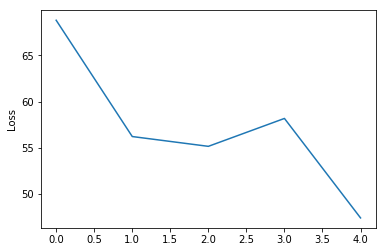

{'accuracy': 0.74210525,
 'accuracy_baseline': 0.63157892,
 'auc': 0.82089287,
 'auc_precision_recall': 0.75926143,
 'average_loss': 0.499235,
 'global_step': 35,
 'label/mean': 0.36842105,
 'loss': 47.427326,
 'prediction/mean': 0.33968458}


In [31]:
title = 'Loss'
data_points_list = [r['loss'] for r in results_list]

plt.ylabel(title)
plt.plot(data_points_list)
plt.show()

pprint.pprint(results_list[-1])

In [22]:
results_list[-1]

{'accuracy': 0.79473686,
 'accuracy_baseline': 0.63157892,
 'auc': 0.88327378,
 'auc_precision_recall': 0.84986967,
 'average_loss': 0.4071424,
 'global_step': 280,
 'label/mean': 0.36842105,
 'loss': 38.678528,
 'prediction/mean': 0.33342153}

In [7]:
final_results_40_epochs_700_batch_size = results_list[-1]
final_results_20_epochs_40_batch_size

{'accuracy': 0.79473686,
 'accuracy_baseline': 0.63157892,
 'auc': 0.83946431,
 'auc_precision_recall': 0.82736772,
 'average_loss': 0.43655688,
 'global_step': 40,
 'label/mean': 0.36842105,
 'loss': 82.945808,
 'prediction/mean': 0.39673224}

In [108]:
# # model prediction using Pandas and 'tf.estimator.inputs.numpy_input_fn'
# import pandas as pd

# test_df = pd.read_csv('input/test.csv')
# pall_pdf = np.array([test_df['Sex']])

# print(pall_pdf.T.shape)

# predict_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={"Sex": pall_pdf.T},
#     num_epochs=1,
#     shuffle=False)

# predictions = model.predict(input_fn=predict_input_fn)
# predicted_classes = [p["classes"][0].decode('utf8') for p in predictions]
# sum((int(x) for x in predicted_classes))

# submission = pd.DataFrame(data={'PassengerId': test_df['PassengerId'], 'Survived': predicted_classes})
# submission.to_csv('input/submission.csv', index=False)
# submission.tail()

(418, 1)
INFO:tensorflow:Restoring parameters from /tmp/titanic/model.ckpt-1401


,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [26]:
# model.predict with TF
csv_columns = ['Pclass', 'Sex', 'Age','SibSp', 'Parch', 'Fare', 'Cabin']
record_defaults = [[0], [''], [0.],
                   [0], [0], [0.], ['']]

def tf_predict_input_fn(data_file):

    def parse_csv(value):
        print('Parsing', data_file)
        columns = tf.decode_csv(value, record_defaults=record_defaults)
        features = dict(zip(csv_columns, columns))
        return features

    # Extract lines from input files using the Dataset API.
    dataset = tf.data.TextLineDataset(data_file).skip(1)

    dataset = dataset.map(parse_csv, num_parallel_calls=5)
    
    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(1) # times to repeat
    dataset = dataset.batch(1) # batch size - NOTE: probably ignored since "repeat=1"

    iterator = dataset.make_one_shot_iterator()
    features = iterator.get_next()
    return features

df = pd.read_csv('input/test.csv')

predictions = model.predict(input_fn=lambda: tf_predict_input_fn(
        data_file='input/test-main.csv'))
predicted_classes = [p["classes"][0].decode('utf8') for p in predictions]
submission = pd.DataFrame(data={
    'PassengerId': df['PassengerId'],
    'Survived': predicted_classes
})
submission.to_csv('input/submission.csv', index=False)

print('Total Survived: {}'.format(sum((int(x) for x in predicted_classes))))

# Submission CSV tail
submission.tail()

Parsing input/test-main.csv
INFO:tensorflow:Restoring parameters from /tmp/titanic/model.ckpt-280
Total Survived: 111


,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [24]:
sum((int(x) for x in predicted_classes))

111

In [134]:
# CSV - trim down "train" feature columns
import csv

read_filename = 'input/train-orig.csv'
write_filename = 'input/train-main.csv'

csv_columns = ['Survived', 'Pclass', 'Sex', 'Age',
               'SibSp', 'Parch', 'Fare', 'Cabin']

with open(read_filename, 'r', newline='') as csv_readfile:
    reader = csv.DictReader(csv_readfile)

    with open(write_filename, 'w', newline='') as csv_writefile:
        fieldnames = csv_columns
        writer = csv.DictWriter(csv_writefile, fieldnames=fieldnames)
        writer.writeheader()
        for line in reader:
            writer.writerow({c: line[c] for c in csv_columns})

In [136]:
# CSV - split "all train data" to: train-set / dev-set
import csv

read_filename = 'input/train-main.csv'
write_filename = 'input/train-main-dev-set.csv'

split = 700

with open(read_filename, 'r', newline='') as csv_readfile:
    reader = csv.DictReader(csv_readfile)

    with open(write_filename, 'w', newline='') as csv_writefile:
        fieldnames = csv_columns
        writer = csv.DictWriter(csv_writefile, fieldnames=fieldnames)

        writer.writeheader()
        for idx, line in enumerate(reader):
            if idx > split:
                writer.writerow({c: line[c] for c in csv_columns})

In [139]:
# test set: remove all columns except for 'Sex'
# No 'Survived' label like the training data
import csv

read_filename = 'input/test-orig.csv'
write_filename = 'input/test-main.csv'

csv_columns = ['Pclass', 'Sex', 'Age',
               'SibSp', 'Parch', 'Fare', 'Cabin']

with open(read_filename, 'r', newline='') as csv_readfile:
    reader = csv.DictReader(csv_readfile)

    with open(write_filename, 'w', newline='') as csv_writefile:
        fieldnames = csv_columns
        writer = csv.DictWriter(csv_writefile, fieldnames=fieldnames)

        writer.writeheader()
        for line in reader:
            writer.writerow({c: line[c] for c in csv_columns})

In [32]:
features

{'Age': <tf.Tensor 'DecodeCSV_25:5' shape=() dtype=float32>,
 'Cabin': <tf.Tensor 'DecodeCSV_25:10' shape=() dtype=string>,
 'Embarked': <tf.Tensor 'DecodeCSV_25:11' shape=() dtype=string>,
 'Fare': <tf.Tensor 'DecodeCSV_25:9' shape=() dtype=float32>,
 'Name': <tf.Tensor 'DecodeCSV_25:3' shape=() dtype=string>,
 'Parch': <tf.Tensor 'DecodeCSV_25:7' shape=() dtype=int32>,
 'PassengerId': <tf.Tensor 'DecodeCSV_25:0' shape=() dtype=int32>,
 'Pclass': <tf.Tensor 'DecodeCSV_25:2' shape=() dtype=int32>,
 'Sex': <tf.Tensor 'DecodeCSV_25:4' shape=() dtype=string>,
 'SibSp': <tf.Tensor 'DecodeCSV_25:6' shape=() dtype=int32>,
 'Survived': <tf.Tensor 'DecodeCSV_25:1' shape=() dtype=int32>,
 'Ticket': <tf.Tensor 'DecodeCSV_25:8' shape=() dtype=string>}

In [34]:
try:
    age = features.pop('Age')
except KeyError:
    # already poped
    pass

age

KeyError: 'Age'

In [37]:
survived = features.pop('Survived')
survived

<tf.Tensor 'DecodeCSV_25:1' shape=() dtype=int32>

In [44]:
import shutil

feature_columns = [age]
hidden_units = [100, 75, 50, 25]
model_dir = '/tmp/titanic/'
train_epochs = 10
epochs_per_eval = 2
batch_size = 50
train_data = 'input/train.csv'
test_data = 'input/test.csv'
num_examples = {
    'train': 750,
    'test': 891-750
}

# CSV file and FeatureColumn setup

filename = "input/train.csv"
csv_columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex',
               'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
               'Cabin', 'Embarked']
record_defaults = [[0], [0], [0], [''], [''],
                   [0.], [0], [0], [''], [0.],
                   [''], ['']]

# Model Config start

run_config = tf.estimator.RunConfig().replace(
  session_config=tf.ConfigProto(device_count={'GPU': 0}))

shutil.rmtree(model_dir, ignore_errors=True)

model = tf.estimator.LinearClassifier(
    model_dir=model_dir,
    feature_columns=feature_columns,
    config=run_config
)

def input_fn(data_file, num_epochs, shuffle, batch_size):

    def parse_csv(value):
        # setup text reader
        file_length = file_len(filename)
        filename_queue = tf.train.string_input_producer([filename])
        reader = tf.TextLineReader(skip_header_lines=1)
        _, csv_row = reader.read(filename_queue)

        # setup CSV decoding
        passenger_id, survived, pclass, name, sex, age, sibsp, parch, ticket, fare, cabin, embarked = tf.decode_csv(csv_row, record_defaults=record_defaults)

        features = dict(zip(
            csv_columns,
            [passenger_id, survived, pclass, name, sex, age, sibsp, parch, ticket, fare, cabin, embarked]))
        age_dict = features.pop('Age')
        return [age_dict], tf.equal(survived, 1)

    # Extract lines from input files using the Dataset API.
    dataset = tf.data.TextLineDataset(data_file)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=num_examples['train'])

    dataset = dataset.map(parse_csv, num_parallel_calls=5)

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)

    iterator = dataset.make_one_shot_iterator()
    features, labels = iterator.get_next()
    return features, labels

# main training run

for n in range(train_epochs // epochs_per_eval):
    model.train(input_fn=lambda: input_fn(
        train_data, epochs_per_eval, True, batch_size))

    results = model.evaluate(input_fn=lambda: input_fn(
        test_data, 1, False, batch_size))

    # Display evaluation metrics
    print('Results at epoch', (n + 1) * epochs_per_eval)
    print('-' * 60)

for key in sorted(results):
    print('%s: %s' % (key, results[key]))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/titanic/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': device_count {
  key: "GPU"
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x114afe6a0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


ValueError: features should be a dictionary of `Tensor`s. Given type: <class 'tensorflow.python.framework.ops.Tensor'>

In [45]:
age_dict

NameError: name 'age_dict' is not defined

In [17]:
pd

<module 'pandas' from '/Users/aaron/Documents/ml/kaggle/digit-recognizer/venv/lib/python3.6/site-packages/pandas/__init__.py'>

In [18]:
a = [0, 1, 20, 21, 31, 32]

pd.qcut(a, 3)

[(-0.001, 13.667], (-0.001, 13.667], (13.667, 24.333], (13.667, 24.333], (24.333, 32.0], (24.333, 32.0]]
Categories (3, interval[float64]): [(-0.001, 13.667] < (13.667, 24.333] < (24.333, 32.0]]

In [25]:
pd.DataFrame(a).mean()

0    17.5
dtype: float64

In [26]:
32/3

10.666666666666666

In [28]:
ret = pd.cut(a, 3)

In [42]:
a = [0, 1, 3, 4, 20, 21, 31, 32]

ret = pd.cut(a, 3)

for i, x in enumerate(ret):
    print(i, x)

0 (-0.032, 10.667]
1 (-0.032, 10.667]
2 (-0.032, 10.667]
3 (-0.032, 10.667]
4 (10.667, 21.333]
5 (10.667, 21.333]
6 (21.333, 32.0]
7 (21.333, 32.0]


In [43]:
ret[0] + ret[1]

TypeError: unsupported operand type(s) for +: 'pandas._libs.interval.Interval' and 'pandas._libs.interval.Interval'